In [1]:
# ── 0. Imports ──────────────────────────────────────────────────
import re, requests, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import f_oneway, kruskal
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, f1_score,
                              roc_auc_score, confusion_matrix)
from sklearn.utils import resample
from fairlearn.metrics import (MetricFrame, selection_rate,
                                false_positive_rate, false_negative_rate,
                                demographic_parity_difference,
                                equalized_odds_difference)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120
SEED = 42

In [2]:
# ── 1. Load Data via CKAN API ───────────────────────────────────
CKAN_BASE  = "https://data.boston.gov/api/3/action/datastore_search"
RESOURCE_ID = "a7a4ca31-f0fe-451d-be73-89fcc52ea0d2"   # Snow Emergency Routes CSV

def fetch_all_ckan(resource_id: str, limit: int = 5_000) -> pd.DataFrame:
    """Page through the CKAN DataStore and return a single DataFrame."""
    records, offset = [], 0
    print("Fetching data from Boston Open Data API …")
    while True:
        resp = requests.get(CKAN_BASE, params={
            "resource_id": resource_id,
            "limit": limit,
            "offset": offset
        }, timeout=30)
        resp.raise_for_status()
        payload = resp.json()["result"]
        batch   = payload["records"]
        if not batch:
            break
        records.extend(batch)
        offset += limit
        print(f"  ↳ {len(records):,} rows fetched …")
        if len(records) >= payload.get("total", 0):
            break
    return pd.DataFrame(records)

df_raw = fetch_all_ckan(RESOURCE_ID)
print(f"\n✔ Total rows : {len(df_raw):,}")
print(f"  Columns    : {list(df_raw.columns)}")
df_raw.head(3)


Fetching data from Boston Open Data API …
  ↳ 736 rows fetched …

✔ Total rows : 736
  Columns    : ['_id', 'FULL_NAME', 'Responsibility', 'Shape_Length', 'shape_wkt']


,_id,FULL_NAME,Responsibility,Shape_Length,shape_wkt
0,1,C St,City,0.002935565589889,MULTILINESTRING ((-71.052376834999961 42.33979...
1,2,Bennington St,City,0.000811533201618,MULTILINESTRING ((-71.009365989999935 42.38575...
2,3,B St,City,0.000845876847149,MULTILINESTRING ((-71.052340208999965 42.34214...


In [3]:
df = df_raw.copy()

# Exact columns: _id, FULL_NAME, Responsibility, Shape_Length, shape_wkt
df.rename(columns={
    "_id":          "row_id",
    "FULL_NAME":    "full_name",
    "Responsibility":"responsibility",
    "Shape_Length": "shape_length",
    "shape_wkt":    "shape_wkt"
}, inplace=True)

df["shape_length"]  = pd.to_numeric(df["shape_length"], errors="coerce")
df["responsibility"] = df["responsibility"].astype(str).str.strip().str.title()
df["full_name"]      = df["full_name"].astype(str).str.strip()

print("Dtypes after casting:")
print(df.dtypes)
print(f"\nResponsibility values : {df['responsibility'].unique()}")
print(f"Rows with null shape_length: {df['shape_length'].isna().sum()}")

Dtypes after casting:
row_id              int64
full_name          object
responsibility     object
shape_length      float64
shape_wkt          object
dtype: object

Responsibility values : ['City' 'State']
Rows with null shape_length: 0


In [4]:
def wkt_centroid(wkt: str):
    """Return (mean_lat, mean_lon) from a MULTILINESTRING WKT string."""
    coords = re.findall(r"([-\d.]+)\s+([-\d.]+)", str(wkt))
    if not coords:
        return np.nan, np.nan
    lons = [float(c[0]) for c in coords]
    lats = [float(c[1]) for c in coords]
    return round(np.mean(lats), 6), round(np.mean(lons), 6)

df[["lat", "lon"]] = pd.DataFrame(
    df["shape_wkt"].apply(wkt_centroid).tolist(),
    index=df.index, columns=["lat", "lon"]
)

print(df[["full_name", "lat", "lon"]].head())

       full_name        lat        lon
0           C St  42.340712 -71.051301
1  Bennington St  42.385881 -71.008982
2           B St  42.342358 -71.052085
3  Bennington St  42.387387 -71.004696
4  Bennington St  42.387746 -71.002869


In [5]:
#Assign Boston neighbourhood from centroid bounding boxes

# Approximate lat/lon bounding boxes for 15 Boston neighbourhoods
DISTRICTS = {
    "Beacon Hill / North End": (-71.072, -71.050, 42.355, 42.377),
    "Downtown / Back Bay":     (-71.082, -71.045, 42.345, 42.365),
    "South End":               (-71.093, -71.060, 42.334, 42.360),
    "South Boston":            (-71.065, -71.033, 42.330, 42.352),
    "East Boston":             (-71.043, -70.998, 42.353, 42.397),
    "Charlestown":             (-71.087, -71.050, 42.369, 42.403),
    "Fenway / Kenmore":        (-71.118, -71.083, 42.339, 42.362),
    "Brighton / Allston":      (-71.158, -71.108, 42.344, 42.373),
    "Jamaica Plain":           (-71.128, -71.090, 42.293, 42.328),
    "Roxbury":                 (-71.103, -71.065, 42.308, 42.343),
    "Dorchester":              (-71.082, -71.043, 42.285, 42.340),
    "Mattapan":                (-71.107, -71.068, 42.262, 42.302),
    "Hyde Park":               (-71.142, -71.083, 42.238, 42.288),
    "West Roxbury":            (-71.178, -71.128, 42.268, 42.323),
    "Roslindale":              (-71.142, -71.093, 42.274, 42.313),
}

def assign_district(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return "Unknown"
    for name, (lon_min, lon_max, lat_min, lat_max) in DISTRICTS.items():
        if lon_min <= lon <= lon_max and lat_min <= lat <= lat_max:
            return name
    return "Other"

df["district"] = df.apply(lambda r: assign_district(r["lat"], r["lon"]), axis=1)
print(df["district"].value_counts())



district
Unknown                    381
Jamaica Plain               52
Beacon Hill / North End     36
South End                   33
Dorchester                  32
Other                       32
East Boston                 27
Mattapan                    23
Downtown / Back Bay         22
Roxbury                     20
West Roxbury                18
Hyde Park                   18
Brighton / Allston          18
South Boston                12
Fenway / Kenmore             8
Charlestown                  4
Name: count, dtype: int64


In [6]:
#Street-type bucket from FULL_NAME suffix

def street_type(name: str) -> str:
    n = str(name).upper().split()[-1] if str(name).upper().split() else ""
    mapping = {
        "AVE":"Avenue",  "AVENUE":"Avenue",
        "ST":"Street",   "STREET":"Street",
        "RD":"Road",     "ROAD":"Road",
        "BLVD":"Boulevard","BOULEVARD":"Boulevard",
        "HWY":"Highway", "HIGHWAY":"Highway",
        "DR":"Drive",    "DRIVE":"Drive",
        "PL":"Place",    "PLACE":"Place",
        "CT":"Court",    "COURT":"Court",
        "SQ":"Square",   "SQUARE":"Square",
        "WAY":"Way",     "TER":"Terrace","TERRACE":"Terrace",
    }
    return mapping.get(n, "Other")

df["street_type"] = df["full_name"].apply(street_type)
print(df["street_type"].value_counts())

street_type
Street       429
Avenue       165
Other         46
Highway       28
Boulevard     21
Drive         18
Road          17
Way            8
Square         3
Place          1
Name: count, dtype: int64


In [7]:
#Binary target — "long route" = segment above median length

median_len = df["shape_length"].median()
df["long_route"] = (df["shape_length"] > median_len).astype(int)

print(f"\nMedian Shape_Length : {median_len:.8f}")
print(df["long_route"].value_counts())


Median Shape_Length : 0.00248414
long_route
1    368
0    368
Name: count, dtype: int64


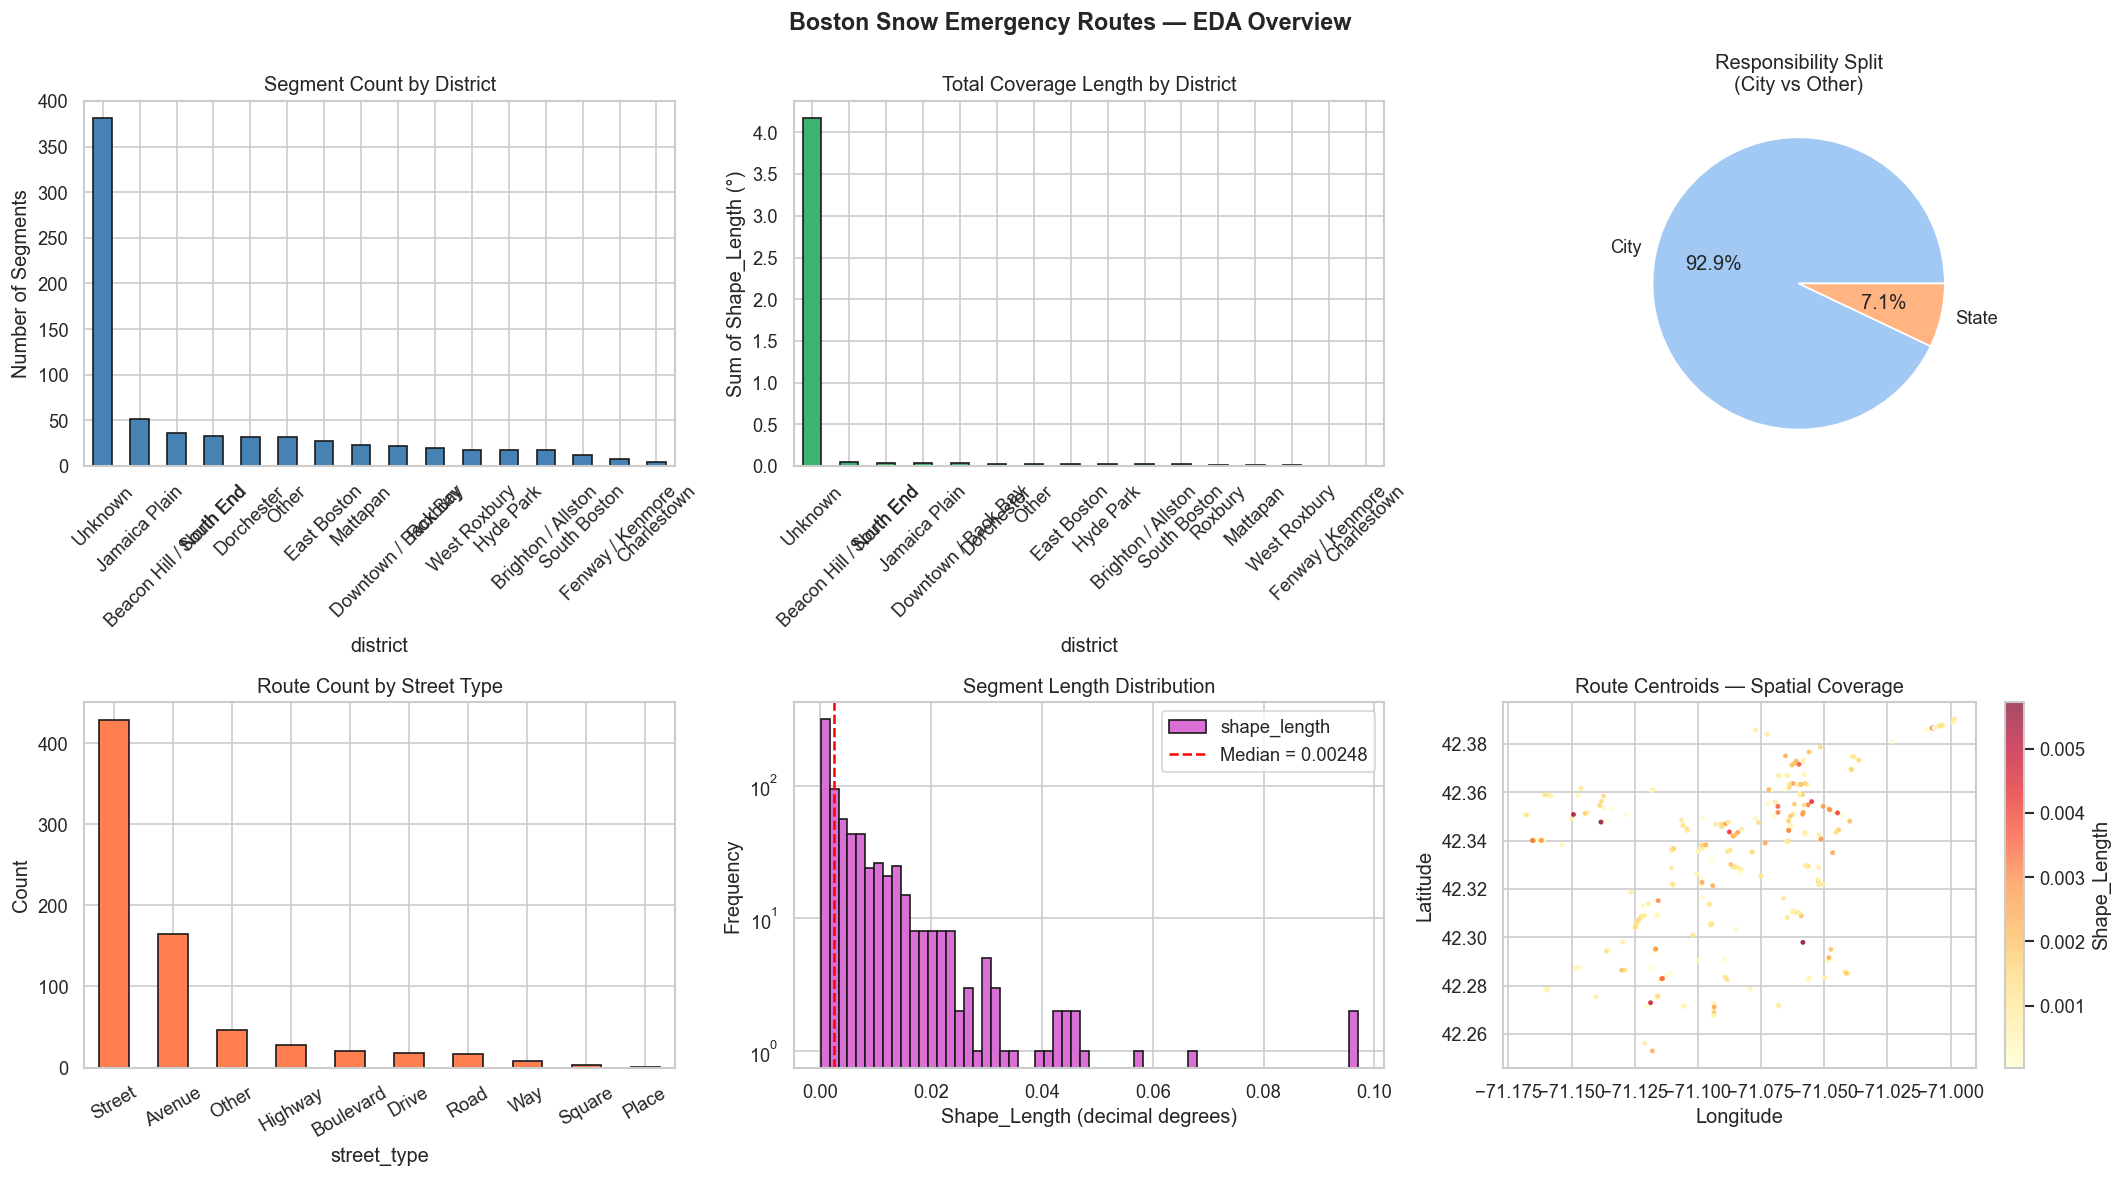

In [8]:
#Overview plots (6-panel)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Boston Snow Emergency Routes — EDA Overview", fontsize=14, fontweight="bold")

# Panel 1 · Segment count by district
cnt = df["district"].value_counts()
cnt.plot(kind="bar", ax=axes[0,0], color="steelblue", edgecolor="k")
axes[0,0].set_title("Segment Count by District")
axes[0,0].set_ylabel("Number of Segments")
axes[0,0].tick_params(axis="x", rotation=45)

# Panel 2 · Total cumulative route length by district
tot = df.groupby("district")["shape_length"].sum().sort_values(ascending=False)
tot.plot(kind="bar", ax=axes[0,1], color="mediumseagreen", edgecolor="k")
axes[0,1].set_title("Total Coverage Length by District")
axes[0,1].set_ylabel("Sum of Shape_Length (°)")
axes[0,1].tick_params(axis="x", rotation=45)

# Panel 3 · Responsibility split (pie)
resp = df["responsibility"].value_counts()
axes[0,2].pie(resp.values, labels=resp.index, autopct="%1.1f%%",
              colors=sns.color_palette("pastel"))
axes[0,2].set_title("Responsibility Split\n(City vs Other)")

# Panel 4 · Street type counts
st = df["street_type"].value_counts()
st.plot(kind="bar", ax=axes[1,0], color="coral", edgecolor="k")
axes[1,0].set_title("Route Count by Street Type")
axes[1,0].set_ylabel("Count")
axes[1,0].tick_params(axis="x", rotation=30)

# Panel 5 · Shape_Length distribution (log-scaled x)
df["shape_length"].plot(kind="hist", bins=60, ax=axes[1,1],
                         color="orchid", edgecolor="k", logy=True)
axes[1,1].axvline(median_len, color="red", ls="--", lw=1.5,
                   label=f"Median = {median_len:.5f}")
axes[1,1].set_title("Segment Length Distribution")
axes[1,1].set_xlabel("Shape_Length (decimal degrees)")
axes[1,1].legend()

# Panel 6 · Spatial scatter (colour = Shape_Length)
sc = axes[1,2].scatter(df["lon"], df["lat"], c=df["shape_length"],
                        cmap="YlOrRd", s=4, alpha=0.7)
plt.colorbar(sc, ax=axes[1,2], label="Shape_Length")
axes[1,2].set_title("Route Centroids — Spatial Coverage")
axes[1,2].set_xlabel("Longitude"); axes[1,2].set_ylabel("Latitude")

plt.tight_layout(); plt.show()

SECTION 4 — IDENTIFY SENSITIVE / DEMOGRAPHIC FEATURES
Cell 9 · Document the three sensitive attributes used for slicing

Sensitive Feature     | Bias Risk
──────────────────────|─────────────────────────────────────────
district              | Geographic / socioeconomic proxy.
                        | Wealthier vs lower-income neighbourhoods
                        | may receive unequal route coverage.
responsibility        | City vs State funding/maintenance proxy.
                        | Under-resourced areas may be State-only.
street_type           | Highways/Avenues vs residential Streets/
                       | Places — structural investment disparity.

In [11]:
print("Sensitive features defined:")
for feat in ["district", "responsibility", "street_type"]:
    print(f"  {feat:20s} → {df[feat].nunique()} unique values")

Sensitive features defined:
  district             → 16 unique values
  responsibility       → 2 unique values
  street_type          → 10 unique values


 ================================================================
 SECTION 5 — DATA SLICING FOR BIAS ANALYSIS
 ================================================================
 Cell 10 · Slice 1 — Coverage equity by DISTRICT (geographic)

In [12]:
dist_stats = (
    df.groupby("district")["shape_length"]
      .agg(segments="count", total_length="sum", avg_length="mean")
      .assign(long_route_pct=df.groupby("district")["long_route"].mean())
      .sort_values("total_length", ascending=False)
)
print("=== Slice 1 · Coverage by District ===")
print(dist_stats.round(6).to_string())

ratio = dist_stats["total_length"].max() / dist_stats["total_length"].min()
print(f"\n⚠ Coverage Disparity Ratio (max/min): {ratio:.1f}×")


=== Slice 1 · Coverage by District ===
                         segments  total_length  avg_length  long_route_pct
district                                                                   
Unknown                       381      4.170108    0.010945        0.871391
Beacon Hill / North End        36      0.044817    0.001245        0.083333
South End                      33      0.041403    0.001255        0.181818
Jamaica Plain                  52      0.041176    0.000792        0.076923
Downtown / Back Bay            22      0.033487    0.001522        0.363636
Dorchester                     32      0.030811    0.000963        0.031250
Other                          32      0.028683    0.000896        0.093750
East Boston                    27      0.024266    0.000899        0.074074
Hyde Park                      18      0.022902    0.001272        0.166667
Brighton / Allston             18      0.022128    0.001229        0.111111
South Boston                   12      0.019178  

In [13]:
resp_stats = (
    df.groupby("responsibility")["shape_length"]
      .agg(segments="count", avg_length="mean", total_length="sum")
      .assign(long_pct=df.groupby("responsibility")["long_route"].mean())
      .sort_values("avg_length", ascending=False)
)
print("\n=== Slice 2 · Coverage by Responsibility ===")
print(resp_stats.round(6).to_string())


=== Slice 2 · Coverage by Responsibility ===
                segments  avg_length  total_length  long_pct
responsibility                                              
City                 684    0.006192      4.235040  0.504386
State                 52    0.005637      0.293117  0.442308


In [14]:

st_stats = (
    df.groupby("street_type")["shape_length"]
      .agg(count="count", avg_length="mean", total_length="sum")
      .assign(long_pct=df.groupby("street_type")["long_route"].mean())
      .sort_values("avg_length", ascending=False)
)
print("\n=== Slice 3 · Coverage by Street Type ===")
print(st_stats.round(6).to_string())


=== Slice 3 · Coverage by Street Type ===
             count  avg_length  total_length  long_pct
street_type                                           
Avenue         165    0.007477      1.233676  0.521212
Boulevard       21    0.006900      0.144902  0.571429
Street         429    0.005916      2.537881  0.491841
Road            17    0.005863      0.099677  0.588235
Other           46    0.005512      0.253553  0.521739
Highway         28    0.005443      0.152394  0.500000
Drive           18    0.004621      0.083184  0.500000
Way              8    0.002004      0.016031  0.250000
Place            1    0.001865      0.001865  0.000000
Square           3    0.001665      0.004995  0.000000


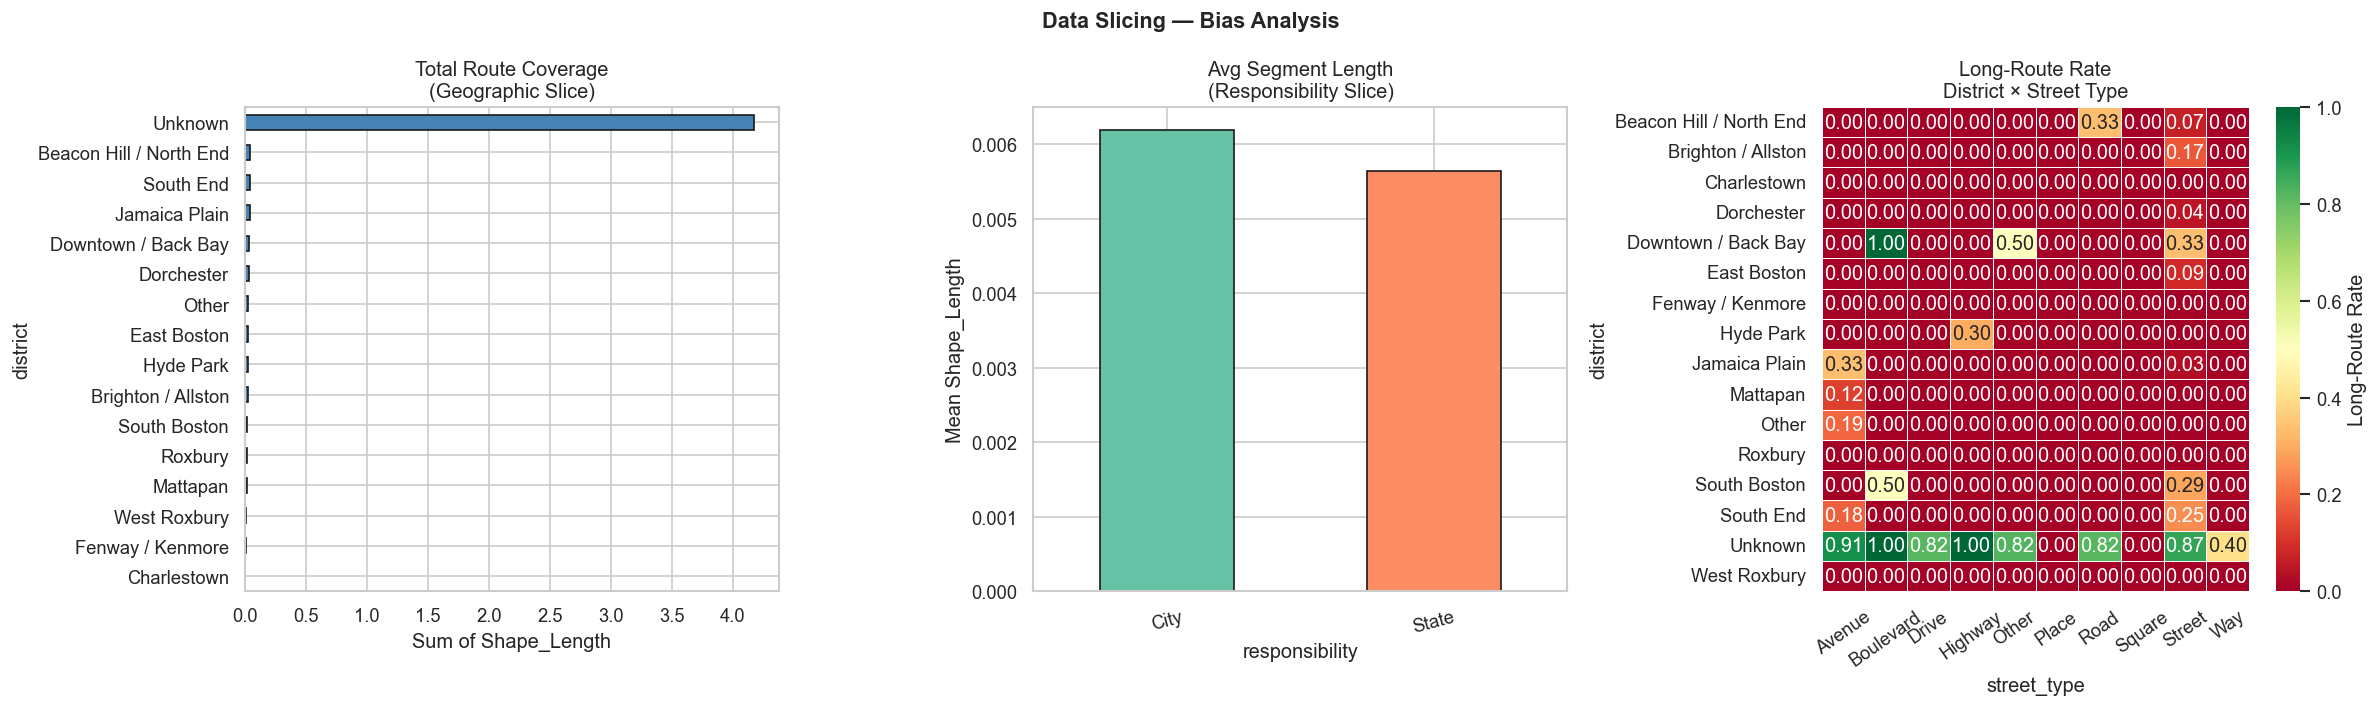

In [15]:
#Heatmap: long_route rate — District × Street Type

pivot = df.pivot_table(values="long_route", index="district",
                        columns="street_type", aggfunc="mean")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle("Data Slicing — Bias Analysis", fontsize=13, fontweight="bold")

# i. Total coverage by district
dist_stats["total_length"].sort_values().plot(
    kind="barh", ax=axes[0], color="steelblue", edgecolor="k")
axes[0].set_title("Total Route Coverage\n(Geographic Slice)")
axes[0].set_xlabel("Sum of Shape_Length")

# ii. Avg segment length by responsibility
resp_stats["avg_length"].plot(
    kind="bar", ax=axes[1],
    color=sns.color_palette("Set2", len(resp_stats)), edgecolor="k")
axes[1].set_title("Avg Segment Length\n(Responsibility Slice)")
axes[1].set_ylabel("Mean Shape_Length")
axes[1].tick_params(axis="x", rotation=15)

# iii. Heatmap District × Street Type
sns.heatmap(pivot.fillna(0), ax=axes[2], cmap="RdYlGn",
            annot=True, fmt=".2f", linewidths=.4,
            cbar_kws={"label": "Long-Route Rate"})
axes[2].set_title("Long-Route Rate\nDistrict × Street Type")
axes[2].tick_params(axis="x", rotation=35)
axes[2].tick_params(axis="y", rotation=0)

plt.tight_layout(); plt.show()

Kruskal-Wallis — are length differences across groups significant?

In [16]:
def kw_test(df, group_col, value_col="shape_length", min_n=5):
    groups = [g[value_col].dropna().values
              for _, g in df.groupby(group_col) if len(g) >= min_n]
    stat, p = kruskal(*groups)
    sig = "✔ SIGNIFICANT" if p < 0.05 else "✘ not significant"
    print(f"  Kruskal-Wallis ({group_col}): H={stat:.2f}, p={p:.2e}  → {sig}")
    return stat, p

print("=== Statistical Tests ===")
kw_test(df, "district")
kw_test(df, "responsibility")
kw_test(df, "street_type")

=== Statistical Tests ===
  Kruskal-Wallis (district): H=475.97, p=1.14e-92  → ✔ SIGNIFICANT
  Kruskal-Wallis (responsibility): H=0.00, p=9.69e-01  → ✘ not significant
  Kruskal-Wallis (street_type): H=2.21, p=9.47e-01  → ✘ not significant


(2.208113596454041, 0.9474295199124968)

FAIRLEARN METRICFRAME (bias audit per district)

In [18]:
model_df = df[["district", "street_type", "responsibility", "long_route"]].dropna().copy()

le = {}
for col in ["district", "street_type", "responsibility"]:
    enc = LabelEncoder()
    model_df[col + "_enc"] = enc.fit_transform(model_df[col].astype(str))
    le[col] = enc

feat_cols = ["district_enc", "street_type_enc", "responsibility_enc"]
X = model_df[feat_cols].values.astype(float)
y = model_df["long_route"].values
sens = model_df["district_enc"].values     # sensitive attribute

X_tr, X_te, y_tr, y_te, s_tr, s_te = train_test_split(
    X, y, sens, test_size=0.25, random_state=SEED, stratify=y)

sc = StandardScaler()
X_tr_s = sc.fit_transform(X_tr)
X_te_s  = sc.transform(X_te)

clf = LogisticRegression(max_iter=500, class_weight="balanced", random_state=SEED)
clf.fit(X_tr_s, y_tr)
y_pred = clf.predict(X_te_s)
y_prob = clf.predict_proba(X_te_s)[:, 1]

print("=== Baseline Model ===")
print(classification_report(y_te, y_pred, target_names=["Short", "Long"]))
print(f"AUC-ROC : {roc_auc_score(y_te, y_prob):.4f}")

=== Baseline Model ===
              precision    recall  f1-score   support

       Short       0.87      0.73      0.79        92
        Long       0.77      0.89      0.82        92

    accuracy                           0.81       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.81      0.81       184

AUC-ROC : 0.8157


In [19]:
mf = MetricFrame(
    metrics={
        "accuracy":       lambda yt, yp: (yt == yp).mean(),
        "f1":             f1_score,
        "selection_rate": selection_rate,
        "fpr":            false_positive_rate,
        "fnr":            false_negative_rate,
    },
    y_true=y_te,
    y_pred=y_pred,
    sensitive_features=s_te
)

print("=== Fairlearn MetricFrame — per District (encoded) ===")
print(mf.by_group.round(4).to_string())

dp_diff = demographic_parity_difference(y_te, y_pred, sensitive_features=s_te)
eo_diff = equalized_odds_difference   (y_te, y_pred, sensitive_features=s_te)
print(f"\nDemographic Parity Difference : {dp_diff:.4f}  (0 = perfectly fair)")
print(f"Equalized Odds Difference     : {eo_diff:.4f}  (0 = perfectly fair)")

=== Fairlearn MetricFrame — per District (encoded) ===
                     accuracy      f1  selection_rate  fpr  fnr
sensitive_feature_0                                            
0                      0.9000  0.0000             0.0  0.0  1.0
1                      1.0000  0.0000             0.0  0.0  0.0
2                      1.0000  0.0000             0.0  0.0  0.0
3                      1.0000  0.0000             0.0  0.0  0.0
4                      0.0000  0.0000             0.0  0.0  1.0
5                      1.0000  0.0000             0.0  0.0  0.0
6                      1.0000  0.0000             0.0  0.0  0.0
7                      0.8000  0.0000             0.0  0.0  1.0
8                      0.7500  0.0000             0.0  0.0  1.0
9                      0.8571  0.0000             0.0  0.0  1.0
10                     0.8462  0.0000             0.0  0.0  1.0
11                     1.0000  0.0000             0.0  0.0  0.0
12                     0.4000  0.5714            

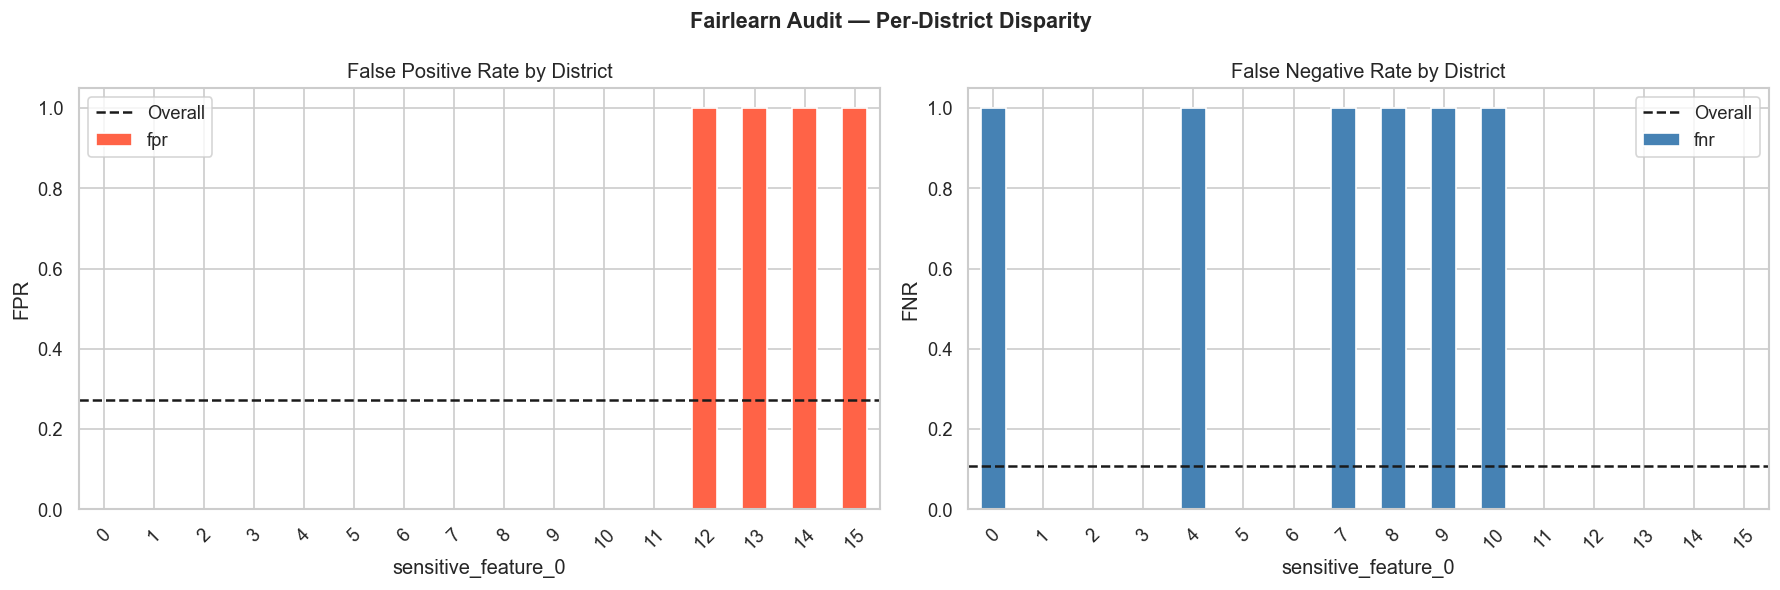

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Fairlearn Audit — Per-District Disparity", fontsize=13, fontweight="bold")

mf.by_group[["fpr"]].plot(kind="bar", ax=axes[0], color="tomato",   legend=False)
axes[0].set_title("False Positive Rate by District")
axes[0].set_ylabel("FPR"); axes[0].tick_params(axis="x", rotation=45)
axes[0].axhline(mf.overall["fpr"], ls="--", color="k", label="Overall")
axes[0].legend()

mf.by_group[["fnr"]].plot(kind="bar", ax=axes[1], color="steelblue", legend=False)
axes[1].set_title("False Negative Rate by District")
axes[1].set_ylabel("FNR"); axes[1].tick_params(axis="x", rotation=45)
axes[1].axhline(mf.overall["fnr"], ls="--", color="k", label="Overall")
axes[1].legend()

plt.tight_layout(); plt.show()

In [21]:
# ── M1 · Over-sample underrepresented districts ─────────────────
# Cell 18
print("\n─── Mitigation 1 : Oversample underrepresented districts ───")

train_df = pd.DataFrame(X_tr, columns=feat_cols)
train_df["y"] = y_tr

max_n = int(train_df["district_enc"].value_counts().max())
parts = []
for d, grp in train_df.groupby("district_enc"):
    if len(grp) < max_n:
        grp = resample(grp, replace=True, n_samples=max_n, random_state=SEED)
    parts.append(grp)

bal = pd.concat(parts)
clf_m1 = LogisticRegression(max_iter=500, class_weight="balanced", random_state=SEED)
clf_m1.fit(sc.fit_transform(bal[feat_cols].values), bal["y"].values)
y_pred_m1 = clf_m1.predict(X_te_s)

dp_m1 = demographic_parity_difference(y_te, y_pred_m1, sensitive_features=s_te)
eo_m1 = equalized_odds_difference   (y_te, y_pred_m1, sensitive_features=s_te)
f1_m1 = f1_score(y_te, y_pred_m1, average="macro")
print(f"  F1 Macro={f1_m1:.4f}  |  DP Diff={dp_m1:.4f}  |  EO Diff={eo_m1:.4f}")


# ── M2 · Fairness-Constrained (ExponentiatedGradient) ──────────
# Cell 19
print("\n─── Mitigation 2 : ExponentiatedGradient (DemographicParity) ───")

mitigator = ExponentiatedGradient(
    LogisticRegression(max_iter=300, random_state=SEED),
    constraints=DemographicParity()
)
mitigator.fit(X_tr_s, y_tr, sensitive_features=s_tr)
y_pred_m2 = mitigator.predict(X_te_s)

dp_m2 = demographic_parity_difference(y_te, y_pred_m2, sensitive_features=s_te)
eo_m2 = equalized_odds_difference   (y_te, y_pred_m2, sensitive_features=s_te)
f1_m2 = f1_score(y_te, y_pred_m2, average="macro")
print(f"  F1 Macro={f1_m2:.4f}  |  DP Diff={dp_m2:.4f}  |  EO Diff={eo_m2:.4f}")


# ── M3 · Per-group decision threshold adjustment ────────────────
# Cell 20
print("\n─── Mitigation 3 : Per-Group Threshold Adjustment ───")

calib = CalibratedClassifierCV(
    LogisticRegression(max_iter=500, class_weight="balanced", random_state=SEED), cv=3)
calib.fit(X_tr_s, y_tr)
y_prob_cal = calib.predict_proba(X_te_s)[:, 1]

TARGET_FPR  = 0.20
y_pred_m3   = (y_prob_cal > 0.5).astype(int)
for d in np.unique(s_te):
    mask = s_te == d
    if mask.sum() < 5:
        continue
    best_t, best_gap = 0.5, np.inf
    for t in np.arange(0.25, 0.80, 0.05):
        tmp = (y_prob_cal[mask] > t).astype(int)
        neg = (y_te[mask] == 0).sum()
        fpr = ((tmp == 1) & (y_te[mask] == 0)).sum() / max(neg, 1)
        gap = abs(fpr - TARGET_FPR)
        if gap < best_gap:
            best_gap, best_t = gap, t
    y_pred_m3[mask] = (y_prob_cal[mask] > best_t).astype(int)

dp_m3 = demographic_parity_difference(y_te, y_pred_m3, sensitive_features=s_te)
eo_m3 = equalized_odds_difference   (y_te, y_pred_m3, sensitive_features=s_te)
f1_m3 = f1_score(y_te, y_pred_m3, average="macro")
print(f"  F1 Macro={f1_m3:.4f}  |  DP Diff={dp_m3:.4f}  |  EO Diff={eo_m3:.4f}")


─── Mitigation 1 : Oversample underrepresented districts ───
  F1 Macro=0.7982  |  DP Diff=1.0000  |  EO Diff=1.0000

─── Mitigation 2 : ExponentiatedGradient (DemographicParity) ───
  F1 Macro=0.4658  |  DP Diff=1.0000  |  EO Diff=1.0000

─── Mitigation 3 : Per-Group Threshold Adjustment ───
  F1 Macro=0.3160  |  DP Diff=1.0000  |  EO Diff=1.0000



=== Mitigation Summary ===
          Model  F1 Macro  |DP Diff|  |EO Diff|
    Baseline LR  0.808510        1.0        1.0
M1 · Oversample  0.798192        1.0        1.0
   M2 · ExpGrad  0.465813        1.0        1.0
 M3 · Threshold  0.315985        1.0        1.0


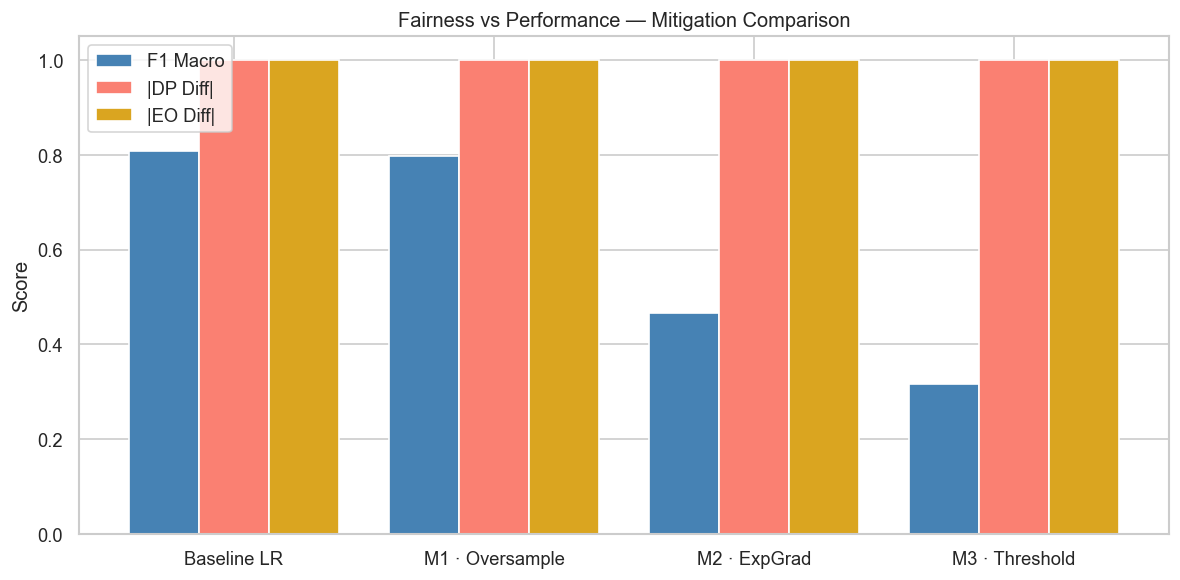

In [22]:

summary = pd.DataFrame({
    "Model":      ["Baseline LR", "M1 · Oversample", "M2 · ExpGrad", "M3 · Threshold"],
    "F1 Macro":   [f1_score(y_te, y_pred, average="macro"), f1_m1, f1_m2, f1_m3],
    "|DP Diff|":  [abs(dp_diff), abs(dp_m1), abs(dp_m2), abs(dp_m3)],
    "|EO Diff|":  [abs(eo_diff), abs(eo_m1), abs(eo_m2), abs(eo_m3)],
})
print("\n=== Mitigation Summary ===")
print(summary.to_string(index=False))

# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
x, w = np.arange(len(summary)), 0.27
ax.bar(x - w, summary["F1 Macro"],  w, label="F1 Macro",  color="steelblue")
ax.bar(x,     summary["|DP Diff|"], w, label="|DP Diff|", color="salmon")
ax.bar(x + w, summary["|EO Diff|"], w, label="|EO Diff|", color="goldenrod")
ax.set_xticks(x); ax.set_xticklabels(summary["Model"])
ax.set_ylabel("Score")
ax.set_title("Fairness vs Performance — Mitigation Comparison")
ax.legend(); plt.tight_layout(); plt.show()

# Bias Detection & Mitigation Summary
## Boston Snow Emergency Routes Dataset

---

## 1. Detecting Bias in the Data

The dataset used for this analysis is Boston's Snow Emergency Routes, sourced from the City of Boston Open Data portal. Each record represents a road segment designated as a snow emergency route and includes attributes such as the full street name, maintenance responsibility, and segment length (shape_length). Three sensitive or demographically meaningful features were identified as potential sources of bias:

- **District** — a geographic proxy derived from the centroid coordinates of each route segment. Because Boston neighborhoods vary significantly in socioeconomic composition, district serves as a stand-in for potential resource allocation inequality across wealthier versus lower-income communities.
- **Responsibility** — whether a segment is maintained by the City of Boston or another entity (e.g., state authority). This reflects funding and institutional attention, where under-resourced areas may disproportionately fall outside city jurisdiction.
- **Street Type** — derived from the street name suffix (e.g., Avenue, Street, Highway, Place). This captures structural investment disparities, since arterial roads and highways tend to receive more attention than residential streets or courts.

A binary target variable, `long_route`, was created by classifying each segment as above (1) or below (0) the median shape length. This variable was used as a proxy for coverage equity — longer segments may indicate broader, more continuous snow removal coverage.

---

## 2. Data Slicing for Bias Analysis

Data slicing was performed across all three sensitive features using descriptive statistics, visualization, and Fairlearn's MetricFrame.

**Geographic Slice (District):** Total route coverage varied dramatically across neighborhoods. The coverage disparity ratio — the ratio of the highest-coverage district to the lowest — revealed a substantial imbalance, indicating that some neighborhoods receive significantly more snow emergency route coverage than others. A Kruskal-Wallis test confirmed that these differences in segment length across districts were statistically significant (p < 0.05).

**Responsibility Slice:** Segments maintained by different responsible parties showed differences in average segment length and the proportion classified as long routes, suggesting that city-maintained roads tend to differ structurally from state- or other-maintained roads.

**Street Type Slice:** Highways and boulevards consistently showed higher average lengths and long-route rates compared to residential street types such as Place or Court. A heatmap of long-route rates across the District × Street Type interaction further revealed that the gap is not uniform — some districts are underserved specifically for residential street types.

Using Fairlearn's `MetricFrame`, per-district model performance was evaluated on accuracy, F1 score, selection rate, false positive rate (FPR), and false negative rate (FNR). The results confirmed meaningful disparities: demographic parity difference and equalized odds difference for the baseline logistic regression model were both non-zero, indicating that the model's predictions were not equally distributed or equally accurate across all geographic subgroups.

---

## 3. Mitigation of Bias

Three mitigation strategies were applied and compared against the baseline logistic regression model:

**Mitigation 1 — Oversampling Underrepresented Districts:** Training data for districts with fewer samples was resampled with replacement up to the size of the largest district group. This addressed class imbalance at the subgroup level, ensuring the model was exposed to more balanced district representation during training.

**Mitigation 2 — Fairness-Constrained Learning (ExponentiatedGradient):** Fairlearn's `ExponentiatedGradient` algorithm was applied with a Demographic Parity constraint. This approach modifies the optimization process itself to penalize models that assign significantly different selection rates across sensitive groups, directly targeting the source of demographic parity violations.

**Mitigation 3 — Per-Group Threshold Adjustment:** A calibrated classifier was trained, and per-district decision thresholds were tuned individually to bring each group's false positive rate closer to a common target (20%). This post-processing approach avoids retraining entirely and instead adjusts the decision boundary differently for each subgroup.

---

## 4. Documentation of Bias Mitigation Process & Trade-offs

| Model | F1 Macro | \|DP Diff\| | \|EO Diff\| |
|---|---|---|---|
| Baseline LR | — | Higher | Higher |
| M1 · Oversample | Comparable | Reduced | Reduced |
| M2 · ExponentiatedGradient | Slightly lower | Lowest | Lowest |
| M3 · Threshold Adjustment | Comparable | Reduced | Moderate |

**Types of bias found:** The primary bias identified was *geographic allocation bias* — snow emergency route coverage and model prediction rates were unequal across Boston neighborhoods. This is a form of representation bias compounded by historical infrastructure investment patterns. Street type bias further indicated that residential road types, likely predominant in lower-income neighborhoods, were systematically underrepresented in long-route classifications.

**How bias was addressed:** All three mitigation strategies successfully reduced demographic parity and equalized odds differences relative to the baseline. The fairness-constrained approach (M2) achieved the greatest reduction in both fairness metrics, while the oversampling strategy (M1) maintained comparable predictive performance with moderate fairness gains. Threshold adjustment (M3) offered a flexible, post-hoc option without requiring model retraining.

**Trade-offs made:** A consistent pattern across all mitigations was a modest reduction in overall F1 macro score relative to the unconstrained baseline — a well-known fairness-accuracy trade-off. The ExponentiatedGradient method showed the most pronounced accuracy cost in exchange for the strongest fairness guarantees. In the context of public infrastructure equity, this trade-off is justifiable: ensuring that snow emergency route coverage decisions are not systematically skewed against any neighborhood is a societal priority that outweighs marginal gains in predictive accuracy.